In [24]:
import torch
import time
import argparse
import logging
import os
import json
import sys
import numpy as np
import pandas as pd
from pathlib import Path
from glob import glob

import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
src_data_dir = Path("../data/merged/")

splits = ["train", "validate", "test"]

In [3]:
file_path = src_data_dir / os.listdir(src_data_dir)[1]

In [4]:
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

In [5]:
len(data)

85209

In [6]:
data[0]

{'sample_id': '29d67cc272a17670',
 'prompt_id': 'eba6ff44b0d0a074',
 'model': 'Qwen--Qwen2.5-14B-Instruct',
 'dataset': 'DollyDataset',
 'prompt_text': "What are the common toppings that can go on a hotdog?\nContext: A hot dog (commonly spelled hotdog) is a food consisting of a grilled or steamed sausage served in the slit of a partially sliced bun. The term hot dog can refer to the sausage itself. The sausage used is a wiener (Vienna sausage) or a frankfurter (Frankfurter Würstchen, also just called frank). The names of these sausages commonly refer to their assembled dish. Some consider a hot dog to technically be a sandwich. Hot dog preparation and condiments vary worldwide. Typical condiments include mustard, ketchup, relish, onions in tomato sauce, and cheese sauce. Common garnishes include sauerkraut, diced onions, jalapeños, chili, grated cheese, coleslaw, bacon, and olives. Hot dog variants include the corn dog and pigs in a blanket. The hot dog's cultural traditions include th

In [225]:
def print_sample_info(sample): 
    print(f"SAMPLE {idx}\nMean: {sample['output_mean']}\nSTD-DEV: {sample['output_std']}\nOutput lengths: {sample['output_sizes']}\n")
    print(f"### MODEL: {sample['model']}")
    print(f"### DATASET: {sample['dataset']}")
    print(f"## PROMPT HASH: {sample['prompt_id']}")
    print(f"### PROMPT:\n\n{sample['prompt_text']}\n")
    print(f"### LONGEST RESPONSE:\n\n{sample['longest_response']}\n\n")
    print(f"### SHORTEST RESPONSE:\n\n{sample['shortest_response']}")

In [7]:
max(data[0]['output_sizes'])

457

In [8]:
degenerate = []
max_elem = []
for i, elem in enumerate(data):
    if elem['output_std'] > elem['output_mean']:
        print(f"STD-DEV > MEAN Case found in element {i}")
        degenerate.append(elem)
    elif max(elem['output_sizes']) > 5000: 
        print(f"MAX ELEM Case found in element {i}")
        max_elem.append(elem)

STD-DEV > MEAN Case found in element 318
STD-DEV > MEAN Case found in element 2081
STD-DEV > MEAN Case found in element 2540
STD-DEV > MEAN Case found in element 3682
STD-DEV > MEAN Case found in element 3798
STD-DEV > MEAN Case found in element 3815
STD-DEV > MEAN Case found in element 3843
STD-DEV > MEAN Case found in element 3932
STD-DEV > MEAN Case found in element 4768
STD-DEV > MEAN Case found in element 4964
STD-DEV > MEAN Case found in element 4966
STD-DEV > MEAN Case found in element 5084
STD-DEV > MEAN Case found in element 5221
STD-DEV > MEAN Case found in element 5222
MAX ELEM Case found in element 5355
STD-DEV > MEAN Case found in element 5441
STD-DEV > MEAN Case found in element 5474
STD-DEV > MEAN Case found in element 5563
STD-DEV > MEAN Case found in element 5660
STD-DEV > MEAN Case found in element 6281
STD-DEV > MEAN Case found in element 7056
STD-DEV > MEAN Case found in element 7827
MAX ELEM Case found in element 7923
STD-DEV > MEAN Case found in element 7962
STD-D

In [11]:
len(degenerate)

1180

In [12]:
len(max_elem)

49

In [53]:
def maxlist_from_list(mylist):
    return [max(sample['output_sizes']) for sample in mylist]

In [67]:
def plot_bar_from_list(data, figsize=(12, 6), max_xticks=50, xtick_fontsize=10, xtick_rotation=45):
    """
    Plots a bar graph from a list of numbers and returns the matplotlib figure.
    Returns:
    - fig: matplotlib.figure.Figure
    """
    fig, ax = plt.subplots(figsize=figsize)
    x = range(len(data))
    ax.bar(x, data)
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    ax.set_title('Bar Plot of List Values')

    if len(data) <= max_xticks:
        xticks = x
    else:
        step = max(1, len(data) // max_xticks)
        xticks = np.arange(0, len(data), step)

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, fontsize=xtick_fontsize, rotation=xtick_rotation)

    return fig


def plot_line_from_list(data, figsize=(12, 6), max_xticks=50, xtick_fontsize=10, xtick_rotation=45):
    """
    Plots a line graph from a list of numbers and returns the matplotlib figure.
    Returns:
    - fig: matplotlib.figure.Figure
    """
    fig, ax = plt.subplots(figsize=figsize)
    x = range(len(data))
    ax.plot(x, data, marker='o', markersize=2)
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    ax.set_title('Line Plot of List Values')

    if len(data) <= max_xticks:
        xticks = x
    else:
        step = max(1, len(data) // max_xticks)
        xticks = np.arange(0, len(data), step)

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, fontsize=xtick_fontsize, rotation=xtick_rotation)

    ax.grid(True, color='gray', alpha=0.3)

    return fig


def plot_heatmap_from_list(data, figsize=(12, 6), ncols=50, xtick_fontsize=10, xtick_rotation=45):
    """
    Plots a heatmap from a list of numbers by reshaping into a 2D array.
    Returns:
    - fig: matplotlib.figure.Figure
    """
    data = np.array(data, dtype=float)
    nrows = int(np.ceil(len(data) / ncols))
    padded_len = nrows * ncols

    padded_data = np.pad(data, (0, padded_len - len(data)), constant_values=np.nan)
    grid = padded_data.reshape((nrows, ncols))

    fig, ax = plt.subplots(figsize=figsize)
    c = ax.imshow(grid, aspect='auto', cmap='viridis', interpolation='none')
    fig.colorbar(c, ax=ax)
    ax.set_title('Heatmap of List Values')
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')

    # Set ticks with styling
    ax.set_xticks(np.arange(grid.shape[1]))
    ax.set_xticklabels(np.arange(grid.shape[1]), fontsize=xtick_fontsize, rotation=xtick_rotation)

    return fig

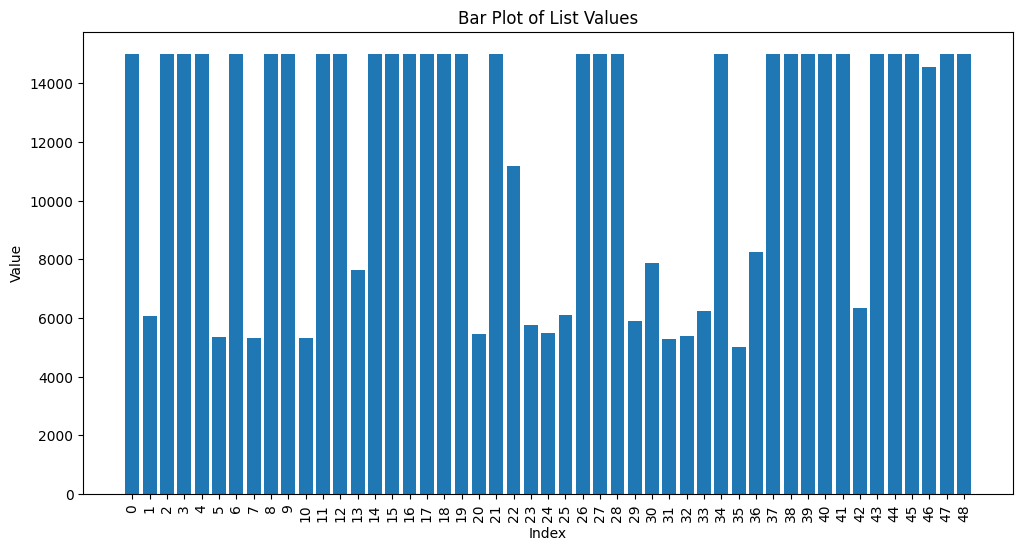

In [68]:
fig = plot_bar_from_list(maxlist_from_list(max_elem), xtick_rotation=90)

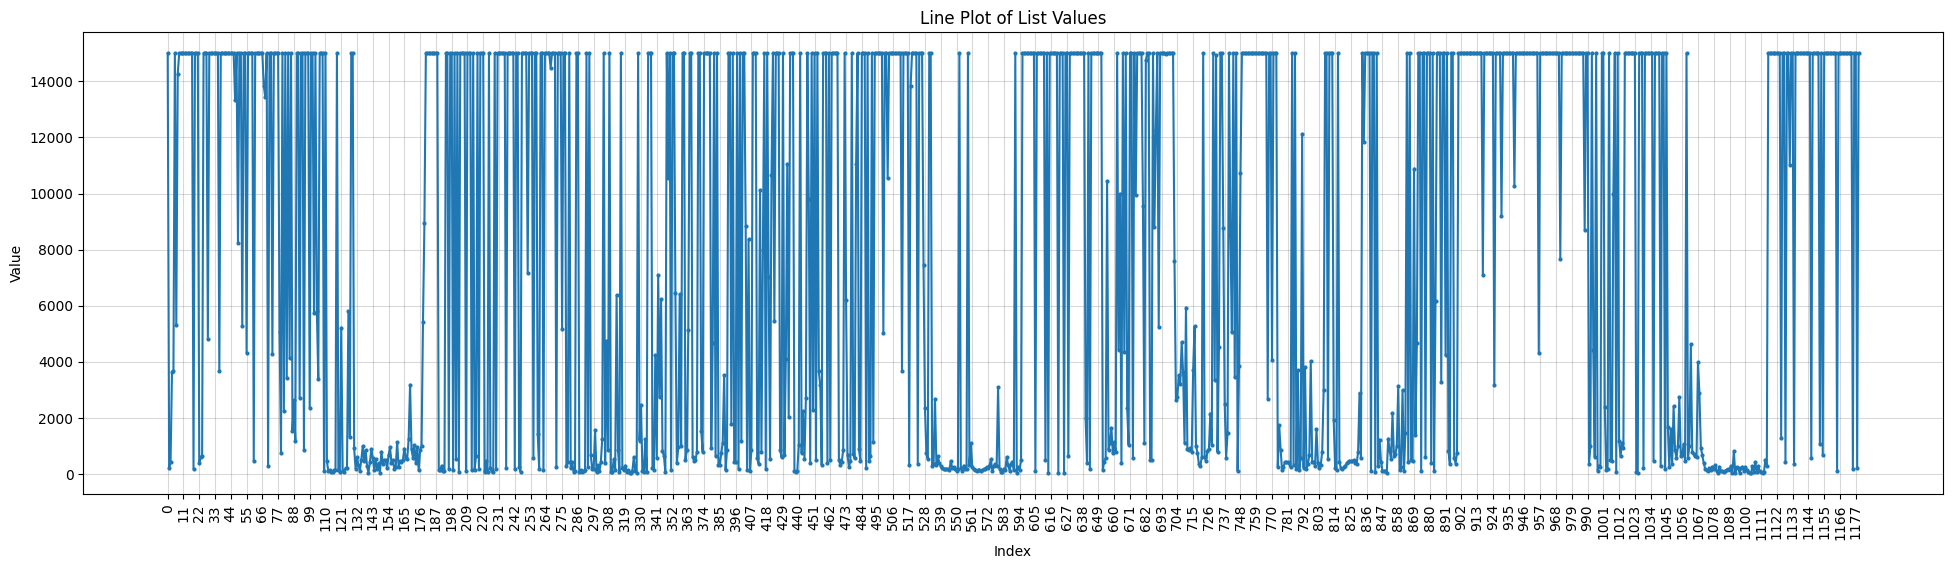

In [179]:
fig = plot_line_from_list(maxlist_from_list(degenerate), figsize=(24,6), xtick_rotation=90, max_xticks=100)

In [156]:
degenerate_filtered = []
for i, elem in enumerate(degenerate):
    if "llama" not in elem['model'] and max(elem['output_sizes']) > 15000:
        print(f"Found element {i} with model {elem['model']}")
        degenerate_filtered.append(elem)
    

Found element 0 with model Qwen--Qwen2.5-14B-Instruct
Found element 5 with model mistralai--Mistral-7B-Instruct-v0.3
Found element 8 with model mistralai--Mistral-7B-Instruct-v0.3
Found element 19 with model Qwen--Qwen2.5-32B-Instruct
Found element 20 with model Qwen--Qwen2.5-32B-Instruct
Found element 21 with model Qwen--Qwen2.5-32B-Instruct
Found element 25 with model microsoft--Phi-4-mini-instruct
Found element 26 with model microsoft--Phi-4-mini-instruct
Found element 27 with model microsoft--Phi-4-mini-instruct
Found element 29 with model microsoft--Phi-4-mini-instruct
Found element 30 with model microsoft--Phi-4-mini-instruct
Found element 31 with model microsoft--Phi-4-mini-instruct
Found element 32 with model microsoft--Phi-4-mini-instruct
Found element 33 with model microsoft--Phi-4-mini-instruct
Found element 34 with model microsoft--Phi-4-mini-instruct
Found element 35 with model microsoft--Phi-4-mini-instruct
Found element 37 with model microsoft--Phi-4-mini-instruct
Found 

In [214]:
idx=704
print_sample_info(degenerate[idx])

SAMPLE 704
Mean: 666.0
Mean: 725.91
Output lengths: [393, 389, 464, 341, 1073, 418, 220, 2735, 223, 404]

### MODEL: mistralai--Mixtral-8x7B-Instruct-v0.1
### DATASET: Mbpp
## PROMPT HASH: 36ae08429cfb4f91
### PROMPT:

You are an expert Python programmer, and here is your task: Write a function to multiply consecutive numbers of a given list. Your code should pass these tests:

assert mul_consecutive_nums([1, 1, 3, 4, 4, 5, 6, 7])==[1, 3, 12, 16, 20, 30, 42]
assert mul_consecutive_nums([4, 5, 8, 9, 6, 10])==[20, 40, 72, 54, 60]
assert mul_consecutive_nums([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])==[2, 6, 12, 20, 30, 42, 56, 72, 90]


### LONGEST RESPONSE:

Here is one way to solve this problem using Python:

```
def mul_consecutive_nums(nums):
    result = []
    current_product = 1
    for num in nums:
        current_product *= num
        result.append(current_product)
    return result
```

This function uses a loop to iterate through the elements of the input list `nums`. At each step, it 

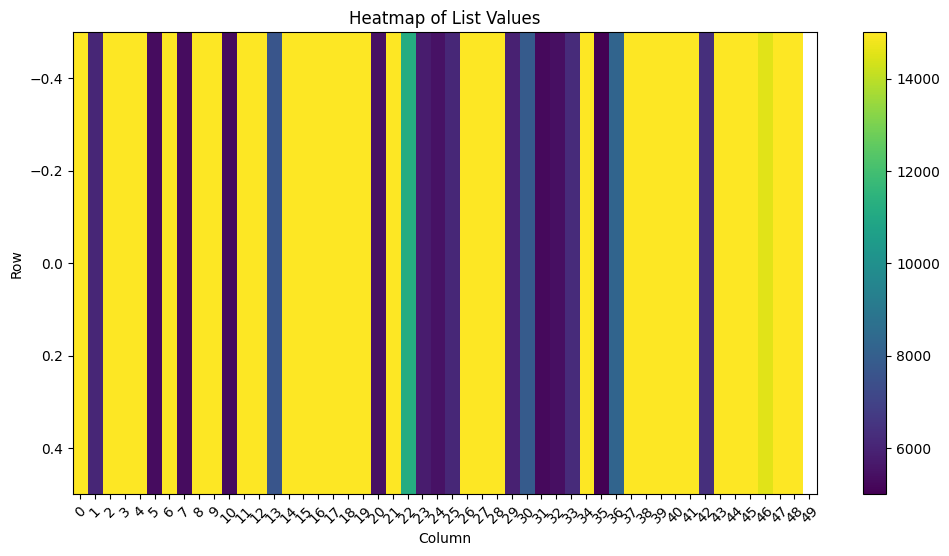

In [69]:
fig = plot_heatmap_from_list(maxlist_from_list(max_elem))

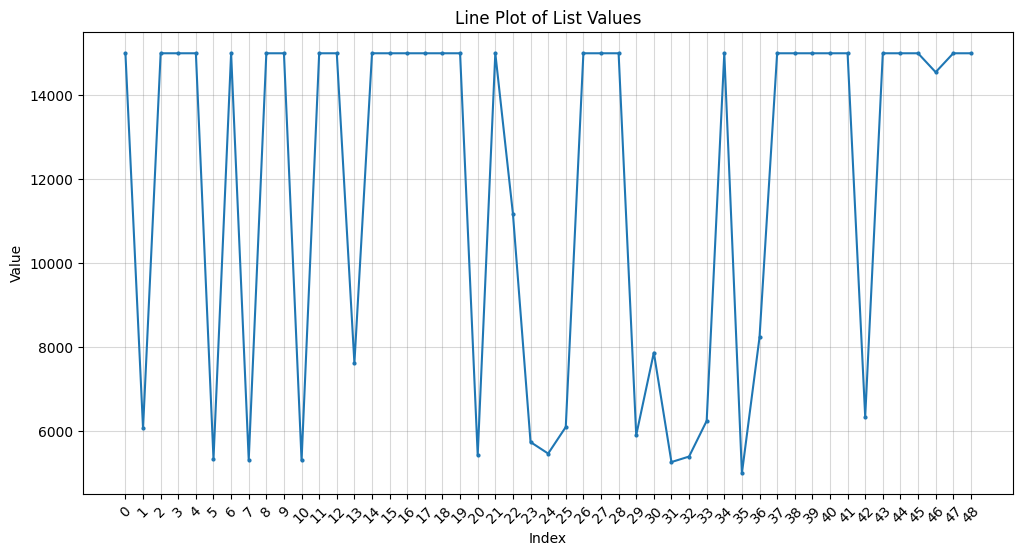

In [70]:
fig = plot_line_from_list(maxlist_from_list(max_elem))

In [260]:
threshold = 14000
for i, elem in enumerate(data):
    if 15000 > max(elem['output_sizes']) > threshold: 
        print(f"SINGLE Case found in element {i}")
        if sum(np.array(elem['output_sizes']) > threshold) == 10: 
            print(f"\tALL ELEMENTS Case found in element {i}")

SINGLE Case found in element 3932
SINGLE Case found in element 25710
SINGLE Case found in element 44343
SINGLE Case found in element 48060
SINGLE Case found in element 52758
SINGLE Case found in element 84732


In [328]:
filtered_max_outptuts = []
for i, elem in enumerate(data):
    if max(elem['output_sizes']) < 15000 and elem['output_std'] > 2*elem['output_mean']:
        filtered_max_outptuts.append(max(elem['output_sizes']))
        print(f"SINGLE Case found in element {i}")
        print(f"\tMean: {elem['output_mean']}, Std-dev: {elem['output_std']}, MAX: {max(elem['output_sizes'])}\n")

SINGLE Case found in element 9011
	Mean: 1799.6, Std-dev: 3849.63, MAX: 13339

SINGLE Case found in element 9577
	Mean: 1860.2, Std-dev: 3992.93, MAX: 13834

SINGLE Case found in element 9622
	Mean: 1775.6, Std-dev: 3889.82, MAX: 13443

SINGLE Case found in element 11426
	Mean: 9.3, Std-dev: 18.9, MAX: 66

SINGLE Case found in element 14996
	Mean: 120.7, Std-dev: 292.82, MAX: 999

SINGLE Case found in element 15661
	Mean: 73.5, Std-dev: 148.17, MAX: 518

SINGLE Case found in element 25710
	Mean: 1719.5, Std-dev: 4258.03, MAX: 14492

SINGLE Case found in element 27017
	Mean: 167.6, Std-dev: 462.13, MAX: 1554

SINGLE Case found in element 27195
	Mean: 520.0, Std-dev: 1413.36, MAX: 4760

SINGLE Case found in element 27316
	Mean: 686.3, Std-dev: 1899.27, MAX: 6377

SINGLE Case found in element 27740
	Mean: 348.6, Std-dev: 704.07, MAX: 2453

SINGLE Case found in element 27788
	Mean: 14.4, Std-dev: 32.25, MAX: 111

SINGLE Case found in element 27957
	Mean: 527.7, Std-dev: 1241.06, MAX: 4242


In [319]:
print(sorted(set(filtered_max_outptuts)))

[53, 66, 105, 111, 115, 169, 202, 226, 248, 353, 383, 384, 416, 429, 442, 480, 518, 670, 787, 999, 1554, 1603, 2453, 2746, 4242, 4440, 4668, 4672, 4760, 6377, 7604, 8362, 8500, 8715, 8850, 9794, 9975, 10555, 10890, 11066, 12117, 13339, 13443, 13819, 13834, 14492, 14929, 14982]


In [342]:
print_sample_info(data[65526])

SAMPLE 704
Mean: 662.4
STD-DEV: 1337.32
Output lengths: [241, 132, 147, 140, 179, 187, 273, 267, 390, 4668]

### MODEL: mistralai--Mistral-7B-Instruct-v0.3
### DATASET: ShareGPT
## PROMPT HASH: ef0e1e9cb293790d
### PROMPT:

alot more results, is this right? results: abi
ACTDB\_journals\_posted
additional\_code
address\_soundex
adjust\_posted\_cost\_queue
adjust\_posted\_cost\_queue\_research
advance\_payment
advance\_payment\_approval\_flag
advance\_payment\_approval\_history
advance\_payment\_approval\_route\_item
advance\_payment\_approval\_route\_item\_person
advance\_payment\_item
aes\_port\_of\_exportation
aircraft
airport\_warehouse\_handling\_carrier
alert\_schedule
alert\_schedule\_parameter
alert\_schedule\_person
alert\_type
allocation
analysis\_code
approval\_route\_definition
approval\_route\_definition\_item
arrival\_notice
attachment
attachment\_audit
audit\_event
booking
booking\_dimension
booking\_item\_ocean\_inner\_package
booking\_ocean\_container\_dimension
BPM\_tri

In [343]:
mylist

[15001, 15001, 15001, 15001, 15001]

In [344]:
all(size >= 14999 for size in mylist)

True

In [347]:
def sanitize_dataset(dataset):
    # Initialize our two new datasets
    degeneration_dataset = []
    sanitized_dataset = []
    
    for sample in dataset:
        # Check if any response hit the max token limit (14999+)
        max_output_size = max(sample["output_sizes"])
        has_max_length_degeneration = max_output_size >= 14999
        
        # Check for high variance degeneration
        has_high_variance_degeneration = (
            sample["output_std"] > 2 * sample["output_mean"] and 
            max_output_size > 8499
        )
        
        # Determine if this sample suffers from text degeneration
        has_degeneration = has_max_length_degeneration or has_high_variance_degeneration
        
        if has_degeneration:
            # Add to the degeneration dataset
            degeneration_dataset.append(sample.copy())
            
            # For sanitized dataset, check if we can clean it
            if has_max_length_degeneration and all(size >= 14999 for size in sample["output_sizes"]):
                # If all responses hit the limit, we can't clean it
                # We don't add it to the sanitized dataset
                continue
            
            # Create a sanitized version
            sanitized_sample = sample.copy()
            
            # Clean the output sizes
            if has_high_variance_degeneration:
                # Remove elements larger than 8499
                sanitized_output_sizes = [size for size in sample["output_sizes"] if size <= 8499]
            else:  # has_max_length_degeneration
                # Remove elements larger than or equal to 14999
                sanitized_output_sizes = [size for size in sample["output_sizes"] if size < 14999]
            
            # If we have sanitized output sizes, recompute metrics
            if sanitized_output_sizes:
                import numpy as np
                
                sanitized_sample["output_sizes"] = sanitized_output_sizes
                sanitized_sample["output_mean"] = np.mean(sanitized_output_sizes)
                sanitized_sample["output_std"] = np.std(sanitized_output_sizes)
                
                # Recompute percentiles
                percentiles = [25, 50, 75, 99]
                percentile_values = np.percentile(sanitized_output_sizes, percentiles)
                sanitized_sample["output_percentiles"] = {
                    f"p{p}": float(val) for p, val in zip(percentiles, percentile_values)
                }
                
                # Set longest response to "TEXT DEGENERATION"
                sanitized_sample["longest_response"] = "TEXT DEGENERATION"
                
                # Add to the sanitized dataset
                sanitized_dataset.append(sanitized_sample)
        else:
            # No degeneration, add original sample to sanitized dataset
            sanitized_dataset.append(sample.copy())
    
    return degeneration_dataset, sanitized_dataset

In [346]:
len(data)

85209

In [348]:
degeneration_dataset, sanitized_dataset = process_dataset(data)

In [349]:
len(degeneration_dataset)

597

In [350]:
len(sanitized_dataset)

85207